Now by training and saving the model in the previous part (Please check it if you havent looked at it yet).
We want to perform interpolation. Here as an example we interpolate between two celltypes: 
    
1) We feed the gene expression of a specific cell-type to AE and compute a the latent layer.
2) Repreat step 1 for the other cell-type.
3) Then use the forward process to map the VAE latent space to DDM.
4) Perfrom interpolation in DDM's prior.
5) Use the reverse process to map the interpolation results in the VAE space.
6) Feed it to the decoder.
7) "Voilà"!!! Now you have interpolated gene expression data.

***Key point 1: As emphasized in the manuscript, the selection of an appropriate number of forward and backward steps is extremely crucial. This choice significantly impacts the quality of the data generation process and influences whether interpolation occurs at finer or coarser levels of detail. (The figure below, extracted from the DDPM paper by Ho et al. illustrates a similar concept.)

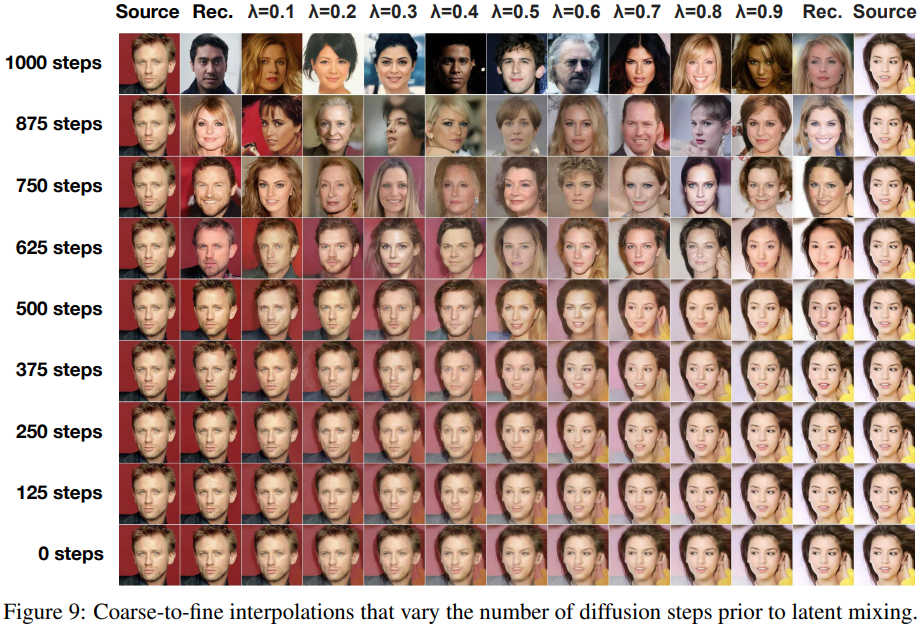


Now lets implement them:

In [ ]:
# In the previous section we had the latent layer values of all cells. So lets subselect a cell-type:
def cell_sample(cell_type):
    # create a Pandas dataframe
    latent_layer_array = pd.DataFrame(latent_layer.numpy())
    latent_layer_pd.index= Data_fin.index
    latent_layer_pd = latent_layer_pd.join(Data_fin['clusters'])
    hspc_df = latent_layer_pd[latent_layer_pd['clusters'] == cell_type]
    data2 = hspc_df.loc[:, hspc_df.columns != 'clusters']
    return data2

Here, I specifically selected subsets of Thrombocytes and HSPCs. Feel free to choose any other cell type you prefer.

In [ ]:
thromb = cell_sample("Thrombocyte")
hspc = cell_sample("HSPC")

Map them to the DDM's prior and interpolate with 2000 equidistance steps

In [ ]:
reprog_diff_latent = q_x(torch.tensor(thromb.iloc[:,:].values), torch.tensor([num_steps-1]))
failed_diff_latent = q_x(torch.tensor(hspc.iloc[:,:].values), torch.tensor([num_steps-1]))
reprog_diff_latent_m = torch.tensor(reprog_diff_latent.mean(axis=0))
failed_diff_latent_m = torch.tensor(failed_diff_latent.mean(axis=0))

alpha = torch.tensor(np.linspace(0, 1, 2000, dtype=np.float32)).to(device)
intp = reprog_diff_latent_m* (1 - alpha[:, None]) + failed_diff_latent_m * alpha[:, None]

In [ ]:
def p_sample_loop2(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """Restore x[T-1], x[T-2]|...x[0] from x[T]"""
    cur_x = intp.to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

In [ ]:
x_seq_zero = p_sample_loop2(model4, intp.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

In [ ]:
cur_x2 = x_seq_zero[len(x_seq_zero)-1].detach().numpy()
umap_emb2 = umap.UMAP(n_neighbors=10, min_dist=0.1).fit_transform(cur_x2)
plt.scatter(umap_emb2[:, 0], umap_emb2[:, 1], s=10);

In [ ]:
with torch.no_grad():
    decod_intrp = model.decoder(x_seq_zero[1500])
column_names = list(Data_fin.columns)  # List of column names from the "data" DataFrame

umap_emb2 = umap.UMAP(n_neighbors=50, min_dist=0.2).fit_transform(decod_intrp)
plt.scatter(umap_emb2[:, 0], umap_emb2[:, 1], s=10);

Assuming you saved the correlation values of each interpolation step with the average gene expression of Thrombocytes and HSPCs, you can plot and see how the correlation changes as we move along the interpolation path (figure 5 in our paper)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume correlations_thromb and correlations_hspc are NumPy arrays with size 2000
# Create an array of x values ranging from 0 to 2000
x = np.arange(2000)  #First I chose a big number here like 20000. Dont do it. Doesnt make any sense at least for this step

# Set plot style
plt.style.use('seaborn-whitegrid')

# Create a figure and axes
fig, ax = plt.subplots()

# Create a line plot of the two series
ax.plot(x, correlations_thromb, label='Thromb', linewidth=1)
ax.plot(x, correlations_hspc, label='HSPC', linewidth=1)

# Add a legend and axis labels
ax.legend()
ax.set_xlabel('Index', fontsize=12)
ax.set_ylabel('Correlation', fontsize=12)

# Set axis tick font size
ax.tick_params(axis='both', labelsize=10)

# Set plot title
plt.title('Correlation between Thromb and HSPC', fontsize=14)

# Adjust plot spacing
plt.tight_layout()

# Show the plot
plt.show()